In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import multiprocessing
from tqdm.notebook import tqdm
from functools import partial


In [2]:
train_data = pd.read_csv('../Dataset/train.csv')
test_data = pd.read_csv('../Dataset/test.csv')
test_data_labels = pd.read_csv('../Dataset/test_labels.csv')
display(train_data.head())
display(test_data.head())
display(test_data_labels.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [3]:
# # Download NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [4]:
# Define preprocessing functions
def clean_text(text):
    """Modified cleaning that preserves important punctuation"""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Instead of removing all special characters, preserve some punctuation
        # that may indicate emotion or emphasis
        text = re.sub(r'[^a-zA-Z\s!?.,;:#]', '', text)
        
        # Replace multiple punctuation with single instances plus a marker
        text = re.sub(r'([!?.])\1+', r'\1 <EMPHASIS> ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    else:
        return ""
    
def normalize_internet_slang(text):
    """Normalize common internet slang and abbreviations"""
    slang_dict = {
        "u": "you", "ur": "your", "r": "are", "2": "to", "4": "for", 
        "b4": "before", "idk": "i don't know", "btw": "by the way",
        "lol": "laughing", "omg": "oh my god", "wtf": "what the f",
        "af": "as f", "lmao": "laughing"
    }
    
    words = text.split()
    normalized_words = [slang_dict.get(word.lower(), word) for word in words]
    return " ".join(normalized_words)

def handle_negations(text):
    """Mark negations to preserve meaning"""
    negation_words = ["no", "not", "never", "none", "nobody", "nothing", "neither", "nowhere", "hardly", "barely", 
                      "scarcely", "doesn't", "isn't", "wasn't", "shouldn't", "wouldn't", "couldn't", "won't", 
                      "can't", "don't"]
    
    words = text.split()
    result = []
    negation_active = False
    
    for i, word in enumerate(words):
        if word.lower() in negation_words:
            negation_active = True
            result.append(word)
        elif negation_active and word in ['.', '!', '?', ',', ';', ':', ')', ']']:
            # End negation scope at punctuation
            negation_active = False
            result.append(word)
        elif negation_active:
            # Mark negated words
            result.append("NEG_" + word)
        else:
            result.append(word)
    
    return " ".join(result)

def add_char_ngrams(text, min_n=3, max_n=4):
    """Add character n-grams to catch intentional misspellings or obfuscated toxic words"""
    words = text.split()
    ngrams = []
    
    for word in words:
        if len(word) > 4:  # Only for longer words where obfuscation is likely
            for n in range(min_n, min(max_n + 1, len(word) + 1)):
                for i in range(len(word) - n + 1):
                    ngrams.append(f"CHAR_{word[i:i+n]}")
    
    return text + " " + " ".join(ngrams)

def custom_stopword_removal(text):
    """Remove stopwords but keep negations and pronouns which are important for toxicity"""
    keep_words = {"no", "not", "he", "she", "they", "them", "their", "you", "your", "i", "me", "my"}
    custom_stopwords = set(stopwords.words('english')) - keep_words
    
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in custom_stopwords]
    return ' '.join(filtered_tokens)

def add_emotion_markers(text):
    """Add markers for potential emotional content"""
    # Uppercase detection (shouting)
    uppercase_ratio = sum(1 for c in text if c.isupper()) / (len(text) or 1)
    
    # Repeated punctuation (emphasis)
    has_repeated_punct = bool(re.search(r'([!?.])\1{2,}', text))
    
    # Add markers
    markers = []
    if uppercase_ratio > 0.3:
        markers.append("<SHOUTING>")
    if has_repeated_punct:
        markers.append("<EMPHASIZED>")
        
    # Return text with markers
    return text + " " + " ".join(markers) if markers else text


def remove_stopwords(text):
    """Remove stopwords from text"""
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_text(text):
    """Lemmatize text"""
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    """Stem text"""
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

def improved_preprocess_text(text):
    """Complete improved preprocessing pipeline"""
    # Basic cleaning with preserving punctuation
    text = clean_text(text)
    
    # Normalize internet slang
    text = normalize_internet_slang(text)
    
    # Handle negations
    # text = handle_negations(text)
    
    # Add emotion markers
    text = add_emotion_markers(text)
    
    # Apply custom stopword removal
    text = custom_stopword_removal(text)
    
    # Lemmatize 
    text = lemmatize_text(text)
    
    # Add character n-grams for longer or potentially obfuscated words
    # text = add_char_ngrams(text)
    
    return text

In [5]:
# train_data

In [6]:

# Function to process a chunk of data
def process_chunk(texts, func):
    return [func(text) for text in texts]

# Function to parallelize preprocessing with progress bar
def parallel_preprocess(texts, preprocess_func, n_cores=None):
    if n_cores is None:
        n_cores = multiprocessing.cpu_count()
    
    # Split the texts into chunks for each core
    n_cores = min(n_cores, len(texts))
    chunk_size = max(1, len(texts) // n_cores)
    chunks = [texts[i:i + chunk_size] for i in range(0, len(texts), chunk_size)]
    
    # Create a partial function with the preprocessing function
    process_func = partial(process_chunk, func=preprocess_func)
    
    # Process in parallel with progress bar
    print(f"Using {n_cores} CPU cores for parallel processing")
    with multiprocessing.Pool(n_cores) as pool:
        results = list(tqdm(
            pool.imap(process_func, chunks),
            total=len(chunks),
            desc="Preprocessing texts"
        ))
    
    # Flatten the results
    return [item for sublist in results for item in sublist]

# Get number of available cores
n_cores = multiprocessing.cpu_count()
print(f"Available CPU cores: {n_cores}")

# Apply improved preprocessing to the datasets
train_processed = train_data.copy()
test_processed = test_data.copy()

# Apply preprocessing with new features using parallel processing
print("Preprocessing training data with enhanced techniques...")
train_processed['processed_text'] = parallel_preprocess(
    train_data['comment_text'].tolist(), 
    improved_preprocess_text,
    n_cores=n_cores
)

print("Preprocessing test data with enhanced techniques...")
test_processed['processed_text'] = parallel_preprocess(
    test_data['comment_text'].tolist(),
    improved_preprocess_text,
    n_cores=n_cores
)

Available CPU cores: 16
Preprocessing training data with enhanced techniques...
Using 16 CPU cores for parallel processing


Preprocessing texts:   0%|          | 0/17 [00:00<?, ?it/s]

Preprocessing test data with enhanced techniques...
Using 16 CPU cores for parallel processing


Preprocessing texts:   0%|          | 0/17 [00:00<?, ?it/s]

Average text length reduction: 27.33%


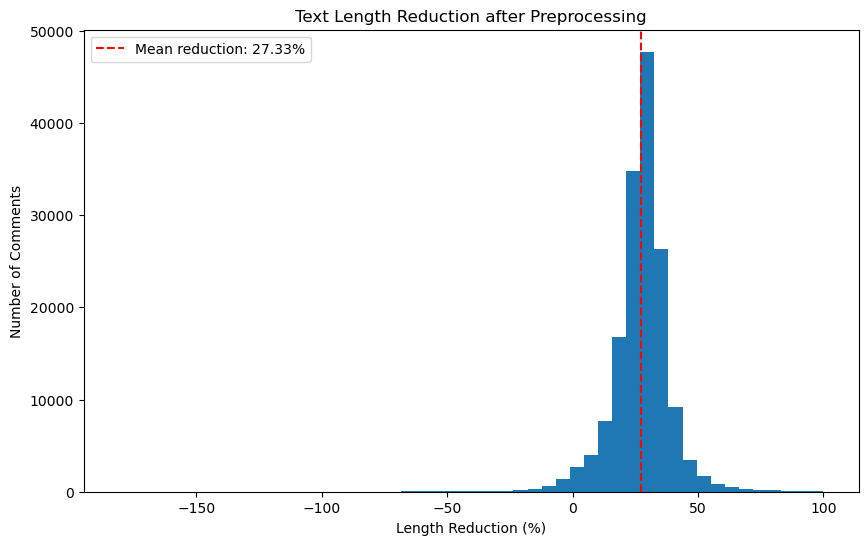

In [7]:
# Analyze the effect of preprocessing
# Check length reduction
train_processed['original_length'] = train_processed['comment_text'].apply(len)
train_processed['processed_length'] = train_processed['processed_text'].apply(len)
train_processed['length_reduction'] = (1 - train_processed['processed_length'] / train_processed['original_length']) * 100

print(f"Average text length reduction: {train_processed['length_reduction'].mean():.2f}%")

# Visualize length reduction
plt.figure(figsize=(10, 6))
plt.hist(train_processed['length_reduction'], bins=50)
plt.axvline(train_processed['length_reduction'].mean(), color='r', linestyle='--', 
           label=f'Mean reduction: {train_processed["length_reduction"].mean():.2f}%')
plt.xlabel('Length Reduction (%)')
plt.ylabel('Number of Comments')
plt.title('Text Length Reduction after Preprocessing')
plt.legend()
plt.show()

Original vocabulary size: 532,299
Processed vocabulary size: 194,086
Vocabulary reduction: 63.54%


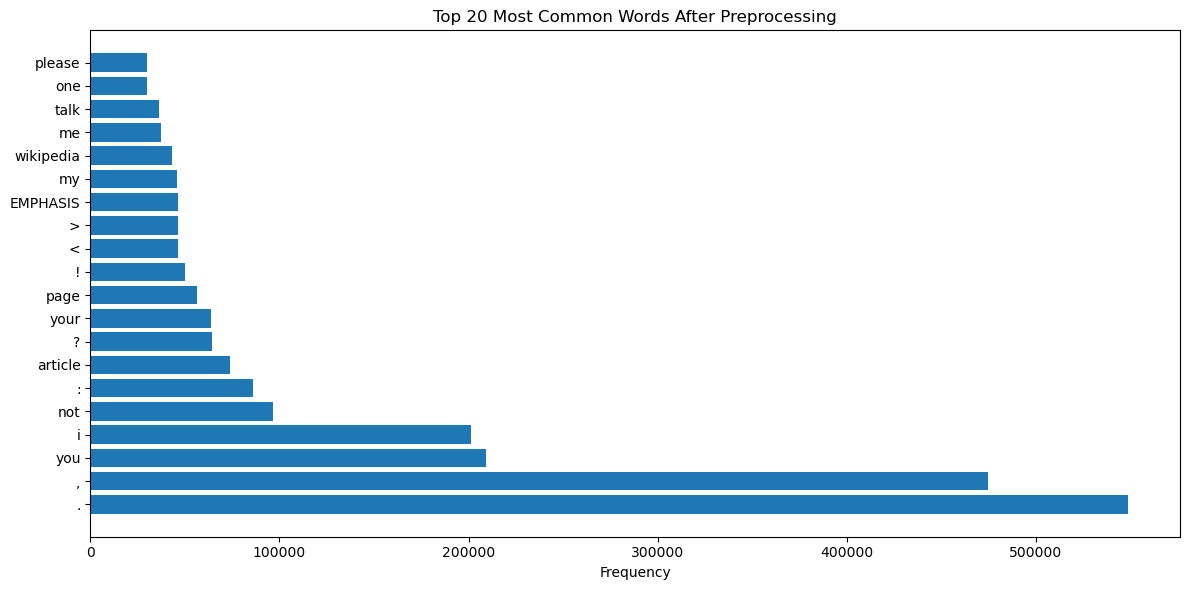

In [8]:
# Look at the vocabulary before and after preprocessing
def get_vocabulary_size(texts):
    all_words = ' '.join(texts).split()
    unique_words = set(all_words)
    return len(unique_words)

original_vocab_size = get_vocabulary_size(train_data['comment_text'])
processed_vocab_size = get_vocabulary_size(train_processed['processed_text'])

print(f"Original vocabulary size: {original_vocab_size:,}")
print(f"Processed vocabulary size: {processed_vocab_size:,}")
print(f"Vocabulary reduction: {(1 - processed_vocab_size / original_vocab_size) * 100:.2f}%")

# Word frequency analysis
from collections import Counter

def plot_top_words(texts, title, n=20):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words).most_common(n)
    words, counts = zip(*word_counts)
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(words)), counts, align='center')
    plt.yticks(range(len(words)), words)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_top_words(train_processed['processed_text'], 'Top 20 Most Common Words After Preprocessing')

In [9]:
# Save the preprocessed data
train_processed.to_csv('../Dataset/train_preprocessed.csv', index=False)
test_processed.to_csv('../Dataset/test_preprocessed.csv', index=False)
print("Preprocessed data saved to CSV files.")

# Final check of the preprocessed data
print("\nPreprocessed training data shape:", train_processed.shape)
print("Preprocessed test data shape:", test_processed.shape)
train_processed.head()

Preprocessed data saved to CSV files.

Preprocessed training data shape: (159571, 12)
Preprocessed test data shape: (153164, 3)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_text,original_length,processed_length,length_reduction
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made my username hardcore me...,264,202,23.484848
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww ! he match background colour im seemingly...,112,86,23.214286
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man , im really not trying edit war . guy ...",233,165,29.184549
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,i cant make real suggestion improvement i wond...,622,406,34.726688
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you , sir , my hero . chance you remember page...",67,54,19.402985


In [10]:
# Advanced preprocessing: Handle class imbalance with oversampling (if needed)


# Create a balanced dataset for each label
def create_balanced_dataset(df, label_column):
    # Separate majority and minority classes
    df_majority = df[df[label_column] == 0]
    df_minority = df[df[label_column] == 1]
    
    # If minority class is very small, oversample it
    if len(df_minority) < len(df_majority) * 0.2:  # arbitrary threshold
        # Oversample minority class
        df_minority_oversampled = resample(
            df_minority, 
            replace=True,  # sample with replacement
            n_samples=int(len(df_majority) * 0.5),  # create minority that's 50% of majority
            random_state=42
        )
        
        # Combine majority class with oversampled minority class
        df_balanced = pd.concat([df_majority, df_minority_oversampled])
        
        print(f"Label '{label_column}': Oversampled from {len(df_minority)} to {len(df_minority_oversampled)} samples")
        return df_balanced
    else:
        print(f"Label '{label_column}': No oversampling needed")
        return df

# Example usage for one toxic label (you can repeat for each label)
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# You can either balance each label separately or use a multi-label approach
# Here's a simple example for the 'toxic' label:
train_balanced_toxic = create_balanced_dataset(train_processed, 'toxic')
print(f"Original class distribution for 'toxic': {train_processed['toxic'].value_counts()}")
print(f"Balanced class distribution for 'toxic': {train_balanced_toxic['toxic'].value_counts()}")

Label 'toxic': Oversampled from 15294 to 72138 samples
Original class distribution for 'toxic': toxic
0    144277
1     15294
Name: count, dtype: int64
Balanced class distribution for 'toxic': toxic
0    144277
1     72138
Name: count, dtype: int64
